In [1]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2022)
import nltk
nltk.download('wordnet')
import pandas as pd
nltk.download('omw-1.4')
import random
import pickle
import pyLDAvis
import pyLDAvis.gensim_models
from datetime import timedelta,datetime
pyLDAvis.enable_notebook()
from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nandu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\nandu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df = pd.read_csv('us_equities_news_dataset.csv') 

In [3]:
stemmer = PorterStemmer()
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    if(text==None):
        return [text]
    text = str(text)
    result = []
    text = re.sub('[,\.!?"\n]', ' ', text)
    text = re.sub("[-:']", ' ', text)
    text = re.sub(' +', ' ', text)
    text_split = text.split()
    for token in text_split:
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) >= 3:
            result.append(lemmatize_stemming(token))
    return result

<>:10: DeprecationWarning: invalid escape sequence '\.'
<>:10: DeprecationWarning: invalid escape sequence '\.'
C:\Users\nandu\AppData\Local\Temp\ipykernel_88076\1930665588.py:10: DeprecationWarning: invalid escape sequence '\.'
  text = re.sub('[,\.!?"\n]', ' ', text)


In [4]:
df.drop('id', axis=1, inplace=True)
df.drop('ticker', axis=1, inplace=True)
df.drop('category', axis=1, inplace=True)
df.drop('url', axis=1, inplace=True)
df.drop('article_id', axis=1, inplace=True)

In [5]:
date_list     = []
headline_list = []
content_list  = []


for index, row in df.iterrows():
    date_tok = row['release_date'].split('-')
    date_list.append(date_tok[0]+'/'+date_tok[1]+'/'+date_tok[2]+'/')
    headline_list.append(preprocess(row['title']))
    content_list.append(preprocess(row['content']))
    if(index%10000==0):
        print(index)
    
df_dict = {'date':date_list,'headline':headline_list,'content':content_list}


f_news_df = pd.DataFrame(df_dict)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000


In [6]:
f_news_df.to_csv('finance-full-data.csv',  encoding='utf-8', index=False)

processed_docs = []
for idx,title in enumerate(headline_list):
    processed_docs.append(title+content_list[idx])


dictionary = gensim.corpora.Dictionary(processed_docs)
print(len(dictionary))
dictionary.filter_extremes(no_below=2, no_above=0.80)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]


with open("f_dictionary",'wb') as fp:
    pickle.dump(dictionary, fp)


299961


In [7]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=15, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.020*"compani" + 0.009*"servic" + 0.009*"busi" + 0.008*"market" + 0.008*"year" + 0.007*"store" + 0.007*"custom" + 0.007*"growth" + 0.007*"retail" + 0.007*"new"
Topic: 1 Word: 0.015*"compani" + 0.014*"drug" + 0.010*"patient" + 0.009*"approv" + 0.008*"studi" + 0.008*"treatment" + 0.008*"year" + 0.007*"stock" + 0.007*"health" + 0.007*"share"
Topic: 2 Word: 0.013*"year" + 0.009*"market" + 0.008*"think" + 0.008*"and" + 0.007*"go" + 0.007*"time" + 0.006*"like" + 0.006*"price" + 0.005*"but" + 0.005*"growth"
Topic: 3 Word: 0.040*"trade" + 0.029*"stock" + 0.028*"close" + 0.026*"point" + 0.024*"nasdaq" + 0.023*"rise" + 0.021*"nyse" + 0.018*"share" + 0.017*"fell" + 0.015*"session"
Topic: 4 Word: 0.014*"market" + 0.014*"trade" + 0.013*"gold" + 0.011*"week" + 0.010*"day" + 0.010*"price" + 0.010*"stock" + 0.008*"high" + 0.007*"level" + 0.007*"look"
Topic: 5 Word: 0.024*"oil" + 0.012*"product" + 0.012*"energi" + 0.012*"price" + 0.011*"year" + 0.010*"ga" + 0.008*"compani" + 0.007*"say"

In [8]:
lda_model.save('f_lda.model')
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary=lda_model.id2word)
pyLDAvis.save_html(vis, 'f_lda.html')

C:\Users\nandu\myenv\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [9]:
df.shape

(221513, 4)

In [10]:
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus)) 


Perplexity:  -7.493232271341126


In [11]:
from gensim.models import CoherenceModel

processed_docs = []
for idx,title in enumerate(headline_list):
    processed_docs.append(title+content_list[idx])

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.47390810307531744


Topic: 0


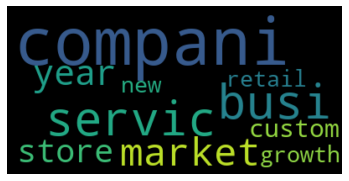

Topic: 1


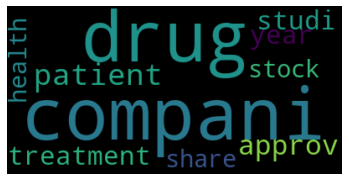

Topic: 2


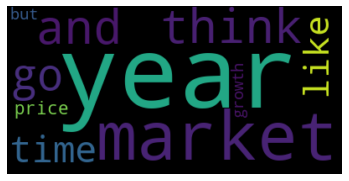

Topic: 3


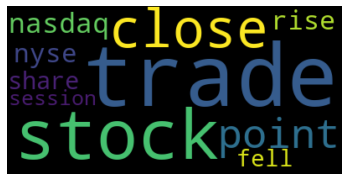

Topic: 4


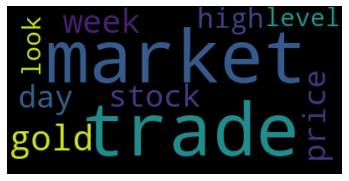

Topic: 5


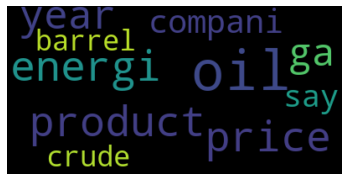

Topic: 6


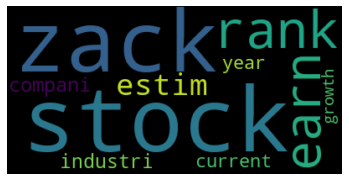

Topic: 7


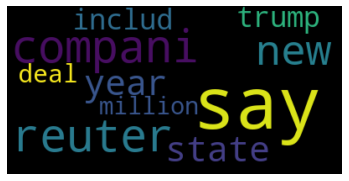

Topic: 8


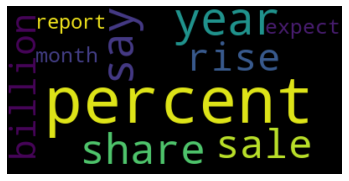

Topic: 9


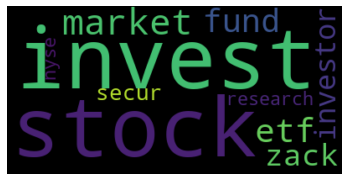

Topic: 10


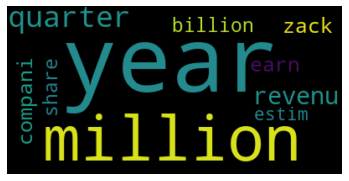

Topic: 11


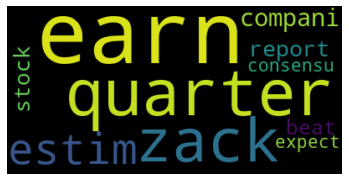

Topic: 12


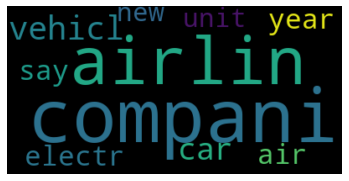

Topic: 13


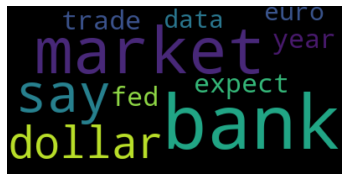

Topic: 14


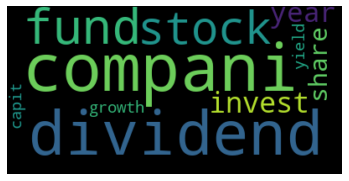

In [12]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {}'.format(idx))
    topic_list = topic.split('+')
    word_freq = {}
    for i,topic_tok in enumerate(topic_list):
        tok_list = topic_tok.strip().split('*')
        word_freq[tok_list[1][1:-1]] = float(tok_list[0])*1000
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=word_freq)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    file_name = 'finance-topic-{}.png'.format(idx)
    wordcloud.to_file(file_name)